# Tutorial Part 17: Training a Generative Adversarial Network on MNIST


In this tutorial, we will train a Generative Adversarial Network (GAN) on the MNIST dataset.  This is a large collection of 28x28 pixel images of handwritten digits.  We will try to train a network to produce new images of handwritten digits.


## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/17_Training_a_Generative_Adversarial_Network_on_MNIST.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands. This will take about 5 minutes to run to completion and install your environment.

In [1]:
%tensorflow_version 1.x
!curl -Lo deepchem_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import deepchem_installer
%time deepchem_installer.install(version='2.3.0')

TensorFlow 1.x selected.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3477  100  3477    0     0   9794      0 --:--:-- --:--:-- --:--:--  9794


add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing deepchem
done
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



deepchem-2.3.0 installation finished!


CPU times: user 2.4 s, sys: 524 ms, total: 2.92 s
Wall time: 1min 55s


To begin, let's import all the libraries we'll need and load the dataset (which comes bundled with Tensorflow).

In [2]:
import deepchem as dc
import tensorflow as tf
from deepchem.models.optimizers import ExponentialDecay
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec
%matplotlib inline

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
images = mnist.train.images.reshape((-1, 28, 28, 1))
dataset = dc.data.NumpyDataset(images)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

Let's view some of the images to get an idea of what they look like.

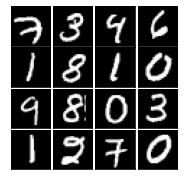

In [3]:
def plot_digits(im):
  plot.figure(figsize=(3, 3))
  grid = gridspec.GridSpec(4, 4, wspace=0.05, hspace=0.05)
  for i, g in enumerate(grid):
    ax = plot.subplot(g)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im[i,:,:,0], cmap='gray')

plot_digits(images)

Now we can create our GAN.  It consists of two parts:

1. The generator takes random noise as its input and produces output that will hopefully resemble the training data.
2. The discriminator takes a set of samples as input (possibly training data, possibly created by the generator), and tries to determine which are which.  Its output is interpreted as a measure of how likely it is that each sample is from the training set.

In [4]:
class DigitGAN(dc.models.WGAN):

  def get_noise_input_shape(self):
    return (10,)

  def get_data_input_shapes(self):
    return [(28, 28, 1)]

  def create_generator(self):
    return tf.keras.Sequential([
        Dense(7*7*8, activation=tf.nn.relu),
        Reshape((7, 7, 8)),
        Conv2DTranspose(filters=16, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same'),
        Conv2DTranspose(filters=1, kernel_size=5, strides=2, activation=tf.sigmoid, padding='same')
    ])

  def create_discriminator(self):
    return tf.keras.Sequential([
        Conv2D(filters=32, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Conv2D(filters=64, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Dense(1, activation=tf.math.softplus)
    ])

gan = DigitGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Now to train it.  The generator and discriminator are both trained together.  The generator tries to get better at fooling the discriminator, while the discriminator tries to get better at distinguishing real data from generated data (which in turn gives the generator a better training signal to learn from).

In [5]:
def iterbatches(epochs):
  for i in range(epochs):
    for batch in dataset.iterbatches(batch_size=gan.batch_size):
      yield {gan.data_inputs[0]: batch[0]}

gan.fit_gan(iterbatches(100), generator_steps=0.2, checkpoint_interval=5000)








Ending global_step 4999: generator average loss 0.561798, discriminator average loss 0.555924
Ending global_step 9999: generator average loss 0.568906, discriminator average loss 0.56287
Ending global_step 14999: generator average loss 0.620129, discriminator average loss 0.613639
Ending global_step 19999: generator average loss 0.57319, discriminator average loss 0.567482
Ending global_step 24999: generator average loss 0.632365, discriminator average loss 0.625501
Ending global_step 29999: generator average loss 0.629756, discriminator average loss 0.623243
Ending global_step 34999: generator average loss 0.59844, discriminator average loss 0.592471
Ending global_step 39999: generator average loss 0.5675, discriminator average loss 0.5617
Ending global_step 44999: generator average loss 0.574203, discriminator average loss 0.568346
Ending global_step 49999: generator average loss 0.562267, discriminator average loss 0.556616
Ending global_step 54999: generator average loss 0.5

Let's generate some data and see how the results look.

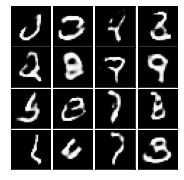

In [6]:
plot_digits(gan.predict_gan_generator(batch_size=16))

Not too bad.  Many of the generated images look plausibly like handwritten digits.  A larger model trained for a longer time can do much better, of course.

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!